In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns


from sklearn.tree import export_graphviz
import matplotlib
import math,graphviz
import pathlib


!pip install -U  graphviz

In [6]:
import re, os
from pandas_summary import DataFrameSummary
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics


In [7]:
PATH = pathlib.Path(".") 


In [8]:
import feather
df_raw = feather.read_dataframe('tmp/bulldozers-raw')


pip install feather-format

In [9]:

def fix_missing(df, col,name):
    if is_numeric_dtype(col):
        if pd.isnull(col).sum():
            df[name + "_na"] = pd.isnull(col)
            df[name] = col.fillna(col.median())

def numericalize(df ,col,name ):
    if not is_numeric_dtype(col) :
        df[name] = pd.Categorical(col).codes+1
        
def proc_df(df , y_fld):

    df = df.copy()
    y = df[y_fld].values
    df.drop([y_fld], axis=1, inplace=True)
    for n,c in df.items():
        fix_missing(df,c,n)
        numericalize(df,c,n)
    return [df , y]



In [10]:
df, y =proc_df(df_raw, "SalePrice")

In [11]:
df.tail().T

,401120,401121,401122,401123,401124
SalesID,6333336,6333337,6333338,6333341,6333342
MachineID,1840702,1830472,1887659,1903570,1926965
ModelID,21439,21439,21439,21435,21435
datasource,149,149,149,149,149
auctioneerID,1,1,1,2,2
...,...,...,...,...,...
saleIs_quarter_start,False,False,False,False,False
saleIs_year_end,False,False,False,False,False
saleIs_year_start,False,False,False,False,False
auctioneerID_na,False,False,False,False,False


In [12]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(df, y)
m.score(df,y)

0.9875137532557655

Wow, an r^2 of 0.98 - that's great, right? Well, perhaps not...

Possibly **the most important idea** in machine learning is that of having separate training & validation data sets. As motivation, suppose you don't divide up your data, but instead use all of it.  And suppose you have lots of parameters:

<img src="images/overfitting2.png" alt="" style="width: 70%"/>
<center>
[Underfitting and Overfitting](https://datascience.stackexchange.com/questions/361/when-is-a-model-underfitted)
</center>

The error for the pictured data points is lowest for the model on the far right (the blue curve passes through the red points almost perfectly), yet it's not the best choice.  Why is that?  If you were to gather some new data points, they most likely would not be on that curve in the graph on the right, but would be closer to the curve in the middle graph.

This illustrates how using all our data can lead to **overfitting**. A validation set helps diagnose this problem.

https://en.wikipedia.org/wiki/Coefficient_of_determination

home work creatre some synethic dataset get feel for r^2 (scatter plot)

In [13]:
a = list(range(100))
n = 12

In [14]:
 train , test = a[n:], a[:n]

In [15]:
test

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [16]:
def split_vals(a,n): 
    return a[:n].copy(), a[n:].copy()

n_valid = 12000  # same as Kaggle's test set size
n_trn = len(df) - n_valid

raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape


((389125, 65), (389125,), (12000, 65), (12000,))

In [28]:
y_train, y_valid = list(map(lambda x : np.log(x), [y_train, y_valid]))

In [30]:
def rmse(x,y): 
    return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [38]:
X_train.Coupler_System

0         0
1         0
2         1
3         0
4         1
         ..
389120    0
389121    0
389122    0
389123    0
389124    0
Name: Coupler_System, Length: 389125, dtype: int8

In [40]:
X_train.YearMade.nunique()

70

In [37]:
dict(X_train.dtypes)

{'SalesID': dtype('int64'),
 'MachineID': dtype('int64'),
 'ModelID': dtype('int64'),
 'datasource': dtype('int64'),
 'auctioneerID': dtype('float64'),
 'YearMade': dtype('int64'),
 'MachineHoursCurrentMeter': dtype('float64'),
 'UsageBand': dtype('int8'),
 'fiModelDesc': dtype('int16'),
 'fiBaseModel': dtype('int16'),
 'fiSecondaryDesc': dtype('int16'),
 'fiModelSeries': dtype('int8'),
 'fiModelDescriptor': dtype('int16'),
 'ProductSize': dtype('int8'),
 'fiProductClassDesc': dtype('int8'),
 'state': dtype('int8'),
 'ProductGroup': dtype('int8'),
 'ProductGroupDesc': dtype('int8'),
 'Drive_System': dtype('int8'),
 'Enclosure': dtype('int8'),
 'Forks': dtype('int8'),
 'Pad_Type': dtype('int8'),
 'Ride_Control': dtype('int8'),
 'Stick': dtype('int8'),
 'Transmission': dtype('int8'),
 'Turbocharged': dtype('int8'),
 'Blade_Extension': dtype('int8'),
 'Blade_Width': dtype('int8'),
 'Enclosure_Type': dtype('int8'),
 'Engine_Horsepower': dtype('int8'),
 'Hydraulics': dtype('int8'),
 'Pushbl

In [31]:
a

print_score(m)

[34788.13829800587, 34101.39864396733, -2529281699.6895213, -2076788914.9302413]


In [32]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.5371269683343529, 0.5674541015387358, 0.39703966649954636, 0.4249449087371777]


In [33]:
def draw_tree(t, df, size=10, ratio=0.6, precision=0):

    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True,
                      special_characters=True, rotate=True, precision=precision)
    display(graphviz.Source(re.sub('Tree {',
       f'Tree {{ size={size}; ratio={ratio}', s)))

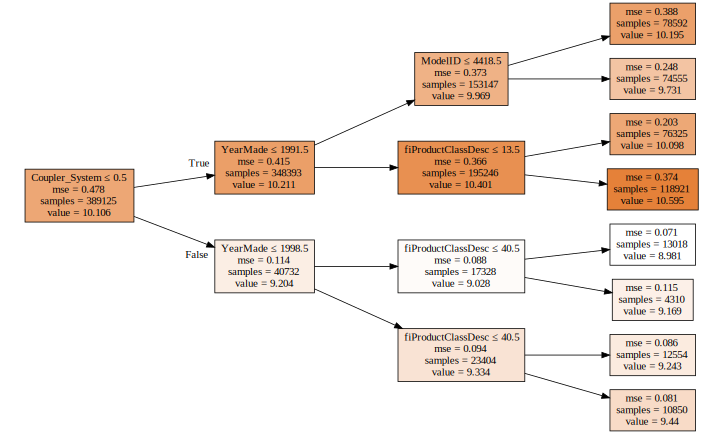

In [34]:
draw_tree(m.estimators_[0], X_train, precision=3)

In [30]:
m = RandomForestRegressor(n_estimators=1, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[8.491571049068883e-07, 0.3502953456206566, 0.999999999998493, 0.7808624974807377]


## Bagging

In [31]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

/home/shilpa/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.09099636066195517, 0.2492770787846707, 0.9826945509603856, 0.8890281906066371]


In [32]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0]), y_valid[0]

(array([9.21034037, 9.21034037, 8.98719682, 8.98719682, 9.39266193,
        9.15904708, 9.21034037, 9.10497986, 9.30565055, 8.98719682]),
 9.15549509923721,
 9.104979856318357)

In [33]:
preds.shape

(10, 12000)

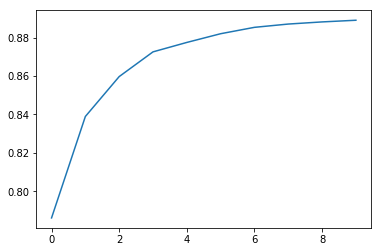

In [35]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)]); #upto i'th tree

In [36]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.0792734590381606, 0.23749112395654695, 0.98686619864165, 0.8992737328243889]


In [37]:
m = RandomForestRegressor(n_estimators=80, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.07676812201530446, 0.23619920913152392, 0.9876832348894224, 0.9003666226371662]


In [39]:
# at some point incresing the number of tree doesnt do good job

Whether to use out-of-bag samples to estimate the generalization accuracy.

In [42]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1,oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.07901110072953949, 0.2388228763084279, 0.9869529883444483, 0.8981409026896316, 0.9069061352674989]


In [43]:
#The number of features to consider when looking for the best split:


In [41]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.12212185435257629, 0.23138836072121097, 0.968831090607062, 0.9043839072752774, 0.9092720192558131]
